In [61]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch

import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [41]:
# MNIST dataset loading
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target.astype(int)

# Stratified sampling 
X_train, _, y_train, _ = train_test_split(X, y, train_size=15000, stratify=y, random_state=42)  # 15000 subset of training data
X_test = X[60000:]  # original 10,000 test samples
y_test = y[60000:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [42]:
# Convert y_train and y_test to numpy arrays before converting to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Create DataLoader objects for PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [43]:
# Define MLP Model in PyTorch
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer
mlp_model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)



In [32]:
def extract_features(loader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in loader:
            x = torch.relu(model.fc1(images))
            x = torch.relu(model.fc2(x))  # Extract features after the second layer
            features.append(x.numpy())
            labels.extend(lbls.numpy())
    return np.concatenate(features), np.array(labels)

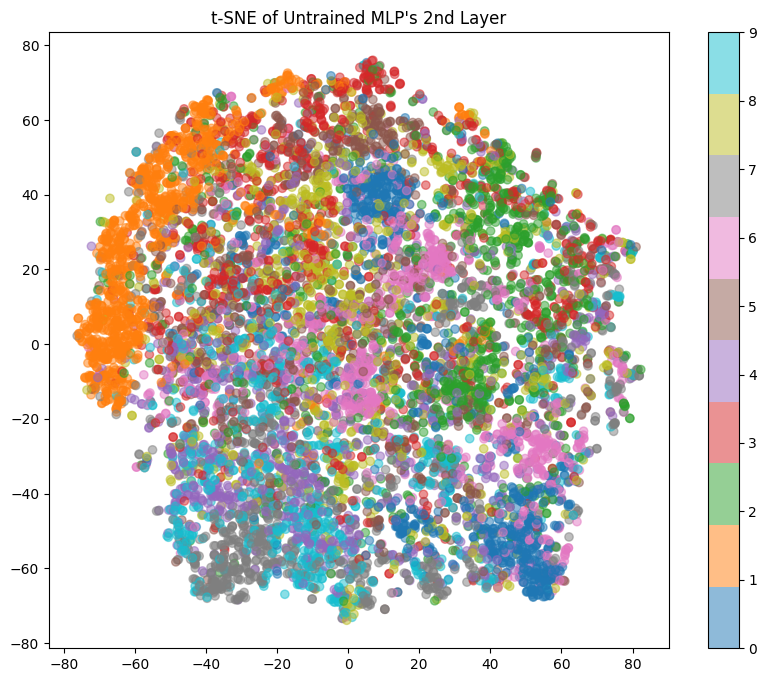

In [33]:
# Initialize an untrained model
untrained_mlp_model = MLP()

# Function to extract features for t-SNE visualization from the second layer


# Extract features for the untrained model
untrained_features, untrained_labels = extract_features(test_loader, untrained_mlp_model)

# t-SNE visualization of the untrained model's embeddings
tsne_untrained = TSNE(n_components=2, random_state=42)
untrained_tsne = tsne_untrained.fit_transform(untrained_features)

plt.figure(figsize=(10, 8))
plt.scatter(untrained_tsne[:, 0], untrained_tsne[:, 1], c=untrained_labels, cmap='tab10', alpha=0.5)
plt.title("t-SNE of Untrained MLP's 2nd Layer")
plt.colorbar()
plt.show()


In [44]:
epochs = 750
for epoch in range(epochs):
    mlp_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = mlp_model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if (epoch+1) % 50 == 0 : 
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss/len(train_loader):.8f}")
    if (running_loss/len(train_loader)) < 1e-8:
        print("\n", f'Stopped at Epoch : {epoch+1} with Loss: {running_loss/len(train_loader)}')
        break


Epoch [50/750], Loss: 0.00042952
Epoch [100/750], Loss: 0.00000189

 Stopped at Epoch : 141 with Loss: 9.73859462811652e-09


In [46]:

# Predict using MLP
mlp_model.eval()
mlp_y_pred = []
with torch.no_grad():
    for images, _ in test_loader:
        output = mlp_model(images)
        _, preds = torch.max(output, 1)
        mlp_y_pred.extend(preds.numpy())
mlp_y_pred = np.array(mlp_y_pred)

# Calculate F1-scores
print("MLP F1 Score:", f1_score(y_test, mlp_y_pred, average="weighted"))
# print("Random Forest F1 Score:", f1_score(y_test, rf_y_pred, average="weighted"))
# print("Logistic Regression F1 Score:", f1_score(y_test, lr_y_pred, average="weighted"))

# # Confusion Matrices
# fig, ax = plt.subplots(1, 3, figsize=(18, 5))
# sns.heatmap(confusion_matrix(y_test, mlp_y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[0])
# ax[0].set_title("MLP Confusion Matrix")

# sns.heatmap(confusion_matrix(y_test, rf_y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[1])
# ax[1].set_title("Random Forest Confusion Matrix")

# sns.heatmap(confusion_matrix(y_test, lr_y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[2])
# ax[2].set_title("Logistic Regression Confusion Matrix")
# plt.show()


MLP F1 Score: 0.9594643625418304


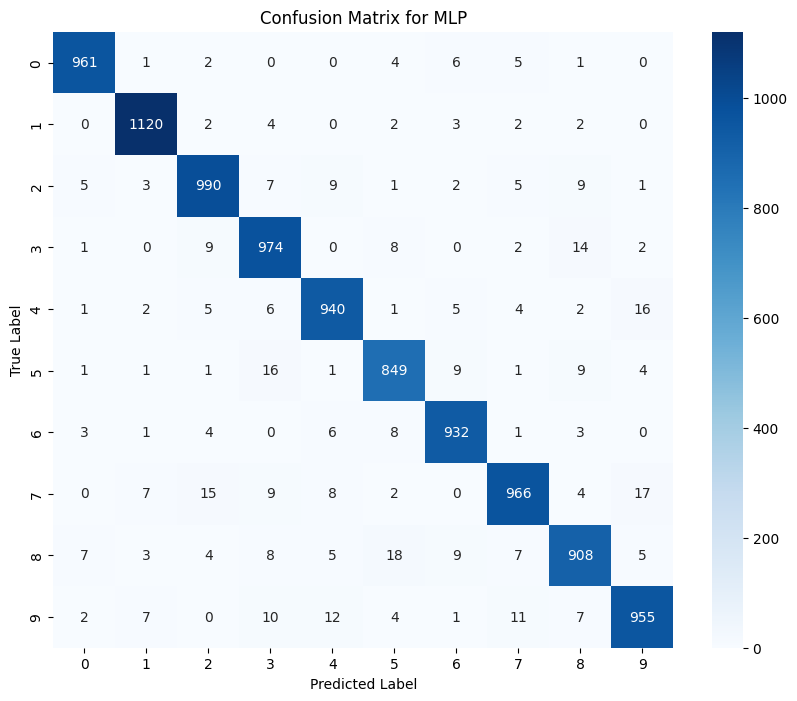

In [50]:
# sns.heatmap(confusion_matrix(y_test, mlp_y_pred), annot=True, fmt='d', cmap='Blues'])
# set_title("MLP Confusion Matrix")

cm_mlp = confusion_matrix(y_test_tensor.numpy(), mlp_y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(i) for i in range(10)], 
            yticklabels=[str(i) for i in range(10)])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for MLP')
plt.show()

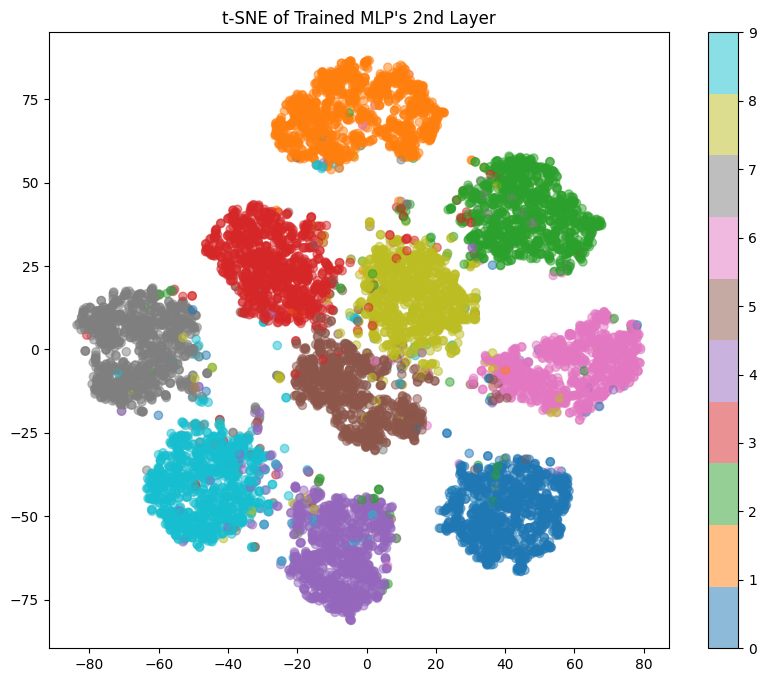

In [51]:
trained_features, trained_labels = extract_features(test_loader, mlp_model)
tsne = TSNE(n_components=2, random_state=42)
trained_tsne = tsne.fit_transform(trained_features)

plt.figure(figsize=(10, 8))
plt.scatter(trained_tsne[:, 0], trained_tsne[:, 1]3, c=trained_labels, cmap='tab10', alpha=0.5)
plt.title("t-SNE of Trained MLP's 2nd Layer")
plt.colorbar()
plt.show()

In [52]:
# Random Forest 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

# Logistic Regression 
lr_model = LogisticRegression(max_iter=2000, random_state=42)
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)

In [53]:
print("MLP F1 Score:", f1_score(y_test, mlp_y_pred, average="weighted"))
print("Random Forest F1 Score:", f1_score(y_test, rf_y_pred, average="weighted"))
print("Logistic Regression F1 Score:", f1_score(y_test, lr_y_pred, average="weighted"))

MLP F1 Score: 0.9594643625418304
Random Forest F1 Score: 0.968277949520531
Logistic Regression F1 Score: 0.910685672845353


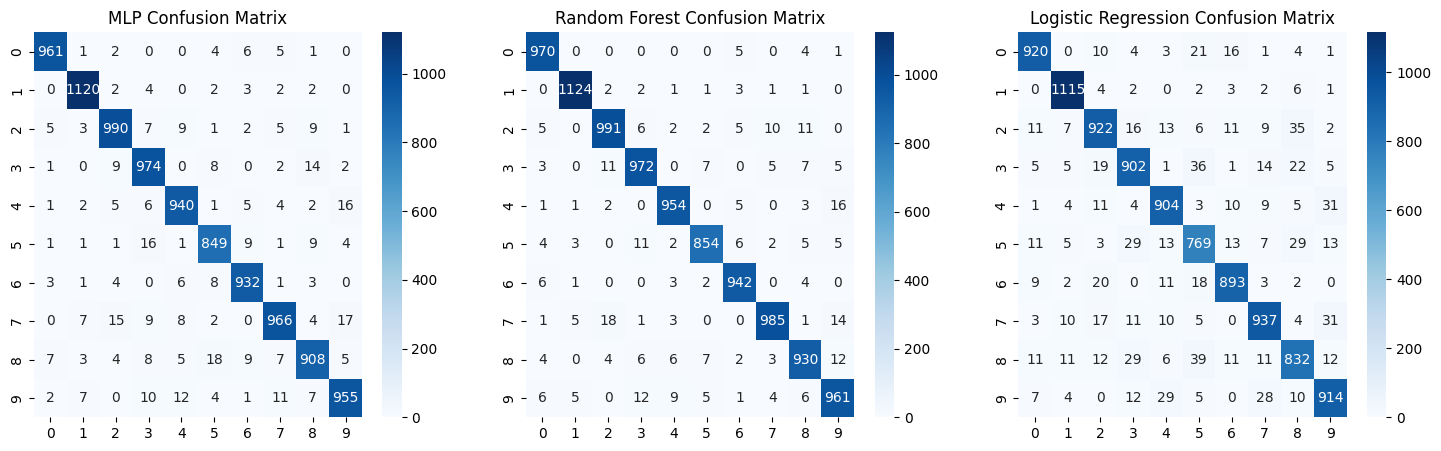

In [54]:
# Confusion Matrices
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(confusion_matrix(y_test, mlp_y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("MLP Confusion Matrix")

sns.heatmap(confusion_matrix(y_test, rf_y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title("Random Forest Confusion Matrix")

sns.heatmap(confusion_matrix(y_test, lr_y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[2])
ax[2].set_title("Logistic Regression Confusion Matrix")
plt.show()

#
#
#
#
Predicting on Fashion-MNIST dataset

In [62]:
from torchvision import datasets, transforms

# Load Fashion-MNIST with similar preprocessing
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
fashion_test = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Flatten the images and create a DataLoader
# Transform fashion_X in the same way as X_test
fashion_X = fashion_test.data.view(-1, 28*28)  # Flatten if not already done
fashion_X = scaler.transform(fashion_X)  # Apply the same scaler fitted on MNIST
fashion_X = torch.tensor(fashion_X, dtype=torch.float32)  # Convert to tensor

# Create DataLoader with preprocessed Fashion-MNIST
fashion_loader = DataLoader(TensorDataset(fashion_X, fashion_test.targets), batch_size=64, shuffle=False)


# Function to predict labels using the trained model
def predict(model, loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():
        for images, _ in loader:
            output = model(images)  # Forward pass
            preds = output.argmax(dim=1)  # Get the predicted class
            predictions.extend(preds.numpy())
    return np.array(predictions)

# Make predictions on the Fashion-MNIST test set
fashion_predictions = predict(mlp_model, fashion_loader)





              precision    recall  f1-score   support

           0       0.02      0.01      0.01      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.01      0.01      0.01      1000
           4       0.50      0.00      0.00      1000
           5       0.04      0.25      0.07      1000
           6       0.24      0.01      0.01      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.03     10000
   macro avg       0.08      0.03      0.01     10000
weighted avg       0.08      0.03      0.01     10000



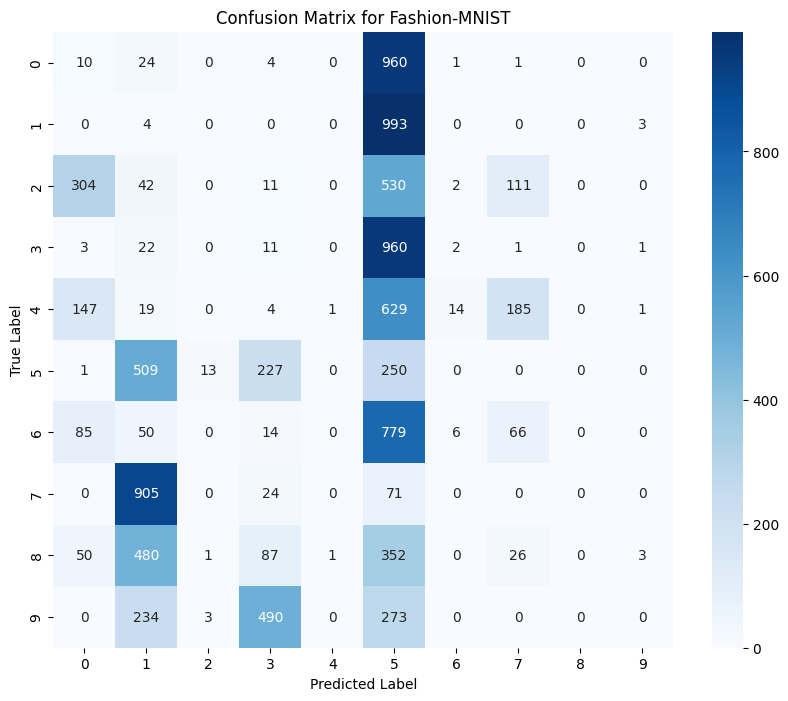

In [63]:
print(classification_report(fashion_test.targets.numpy(), fashion_predictions))

cm_fashion = confusion_matrix(fashion_test.targets.numpy(), fashion_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_fashion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(i) for i in range(10)], 
            yticklabels=[str(i) for i in range(10)])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Fashion-MNIST')
plt.show()

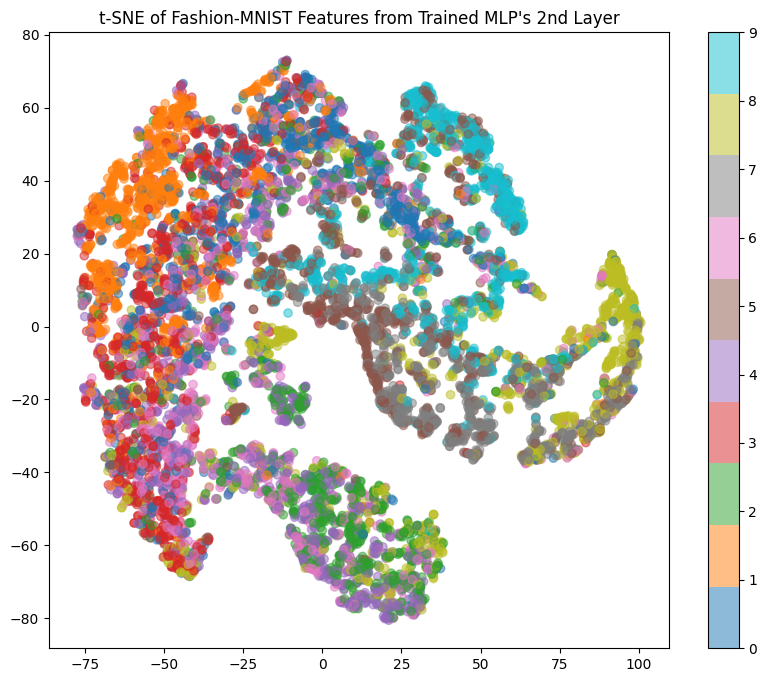

In [64]:
# Extract features from the second layer for t-SNE visualization
fashion_features, fashion_labels = extract_features(fashion_loader, mlp_model)

# Perform t-SNE on the Fashion-MNIST features
tsne = TSNE(n_components=2, random_state=42)
fashion_tsne = tsne.fit_transform(fashion_features)

# Visualize t-SNE
plt.figure(figsize=(10, 8))
plt.scatter(fashion_tsne[:, 0], fashion_tsne[:, 1], c=fashion_labels, cmap='tab10', alpha=0.5)
plt.title("t-SNE of Fashion-MNIST Features from Trained MLP's 2nd Layer")
plt.colorbar()
plt.show()